Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 1400x1200 with 0 Axes>

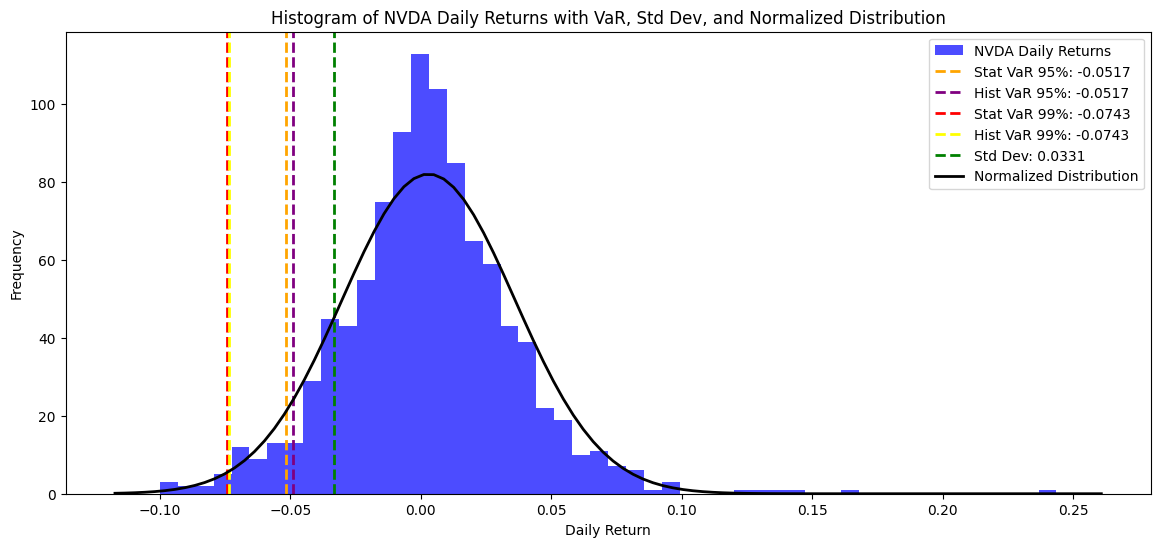

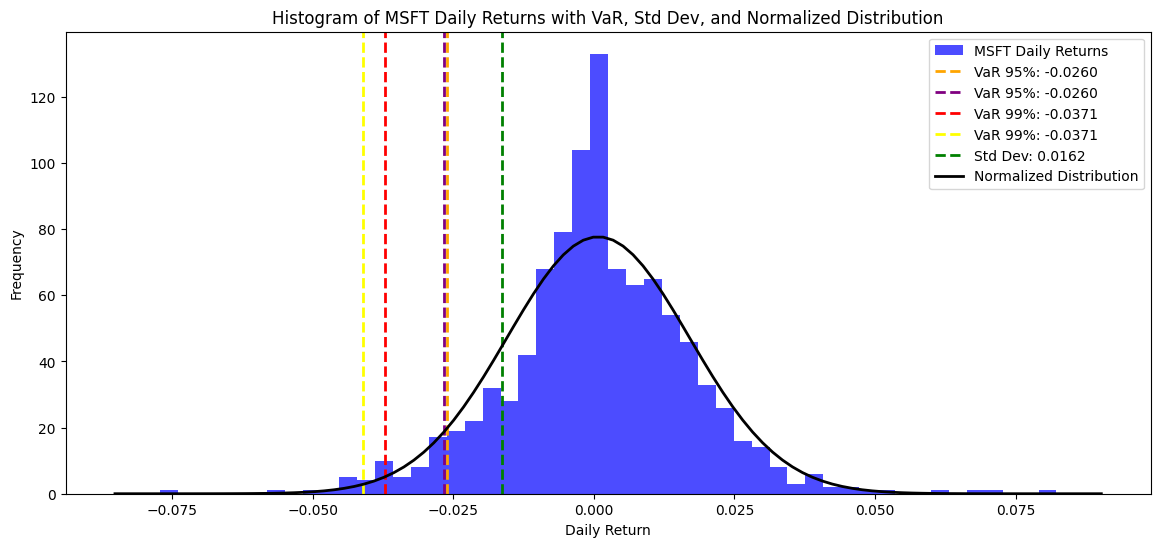

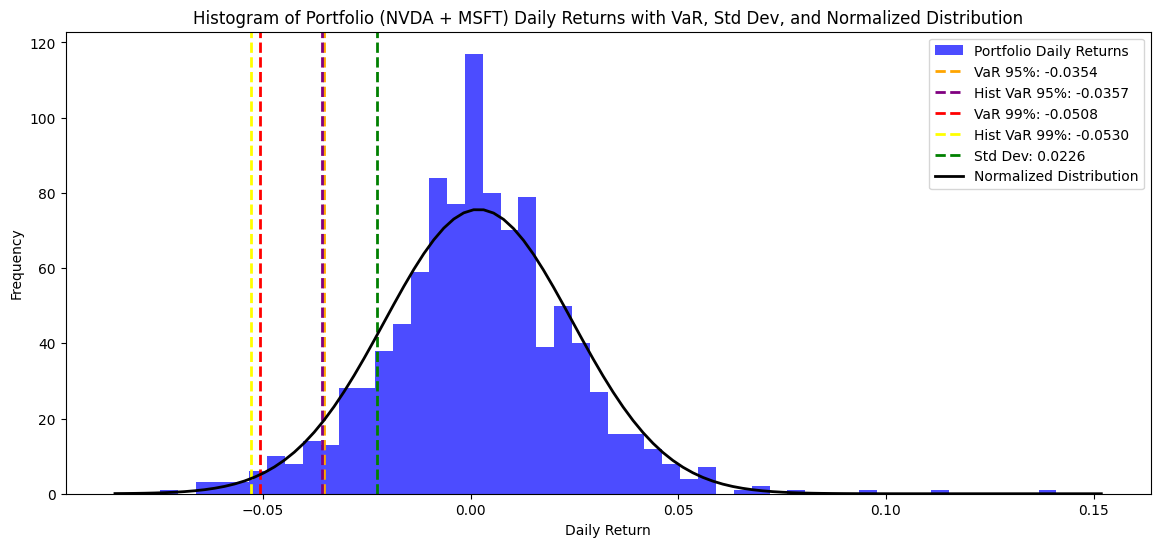

<Figure size 640x480 with 0 Axes>

                           Metric      NVDA      MSFT  Portfolio
0           Statistical VaR (95%) -0.051722 -0.026014        NaN
1            Statistical ES (95%) -0.064823 -0.032436        NaN
2           Statistical VaR (99%) -0.074259 -0.037061        NaN
3            Statistical ES (99%) -0.084620 -0.042140        NaN
4   Variance-Covariance VaR (95%)       NaN       NaN  -0.035419
5    Variance-Covariance ES (95%)       NaN       NaN  -0.044355
6   Variance-Covariance VaR (99%)       NaN       NaN  -0.050790
7    Variance-Covariance ES (99%)       NaN       NaN  -0.057857
8            Historical VaR (95%) -0.048930 -0.026604  -0.035744
9             Historical ES (95%) -0.066156 -0.035597  -0.046904
10           Historical VaR (99%) -0.073485 -0.041056  -0.052985
11            Historical ES (99%) -0.086755 -0.048914  -0.061384


In [7]:
# Inspiration for code from: https://blog.quantinsti.com/calculating-value-at-risk-in-excel-python/

# Import appropriate libraries:
# pandas: data alteration and analysis
# numpy: numerical operations
# matplotlib.pyplot: graph plotting
# scipy.stats: calculating normalised distribution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import and load the datasets saved as Excel spreadsheet in Google Drive.
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Book1.xlsx'
xls = pd.ExcelFile(file_path)

# Extracts data from only the first sheet of Excel file for working.
sheet1_df = pd.read_excel(xls, 'Sheet1')

# Ignore irrelevant columns at the top of the excel file.
cleaned_df = sheet1_df.iloc[4:].copy()  # Starting from row 4 to skip metadata
cleaned_df.columns = ['Date', 'NVDA', 'Empty1', 'Date2', 'MSFT']
cleaned_df = cleaned_df[['Date', 'NVDA', 'MSFT']]  # Keep only the relevant columns

# Ignore rows with NaN values.
cleaned_df = cleaned_df.dropna()

# Converting columns to appropriate data types.
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date']) # Set to datetime format.
cleaned_df['NVDA'] = pd.to_numeric(cleaned_df['NVDA'], errors='coerce') # Set to numerical format.
cleaned_df['MSFT'] = pd.to_numeric(cleaned_df['MSFT'], errors='coerce') # Set to numerical format.

# Ignore any remaining rows with NaN after setting data types.
cleaned_df = cleaned_df.dropna()

# Set 'Date' column as index of dataframe and modify directly in place.
cleaned_df.set_index('Date', inplace=True)

# Calculating daily returns for both companies and drop NaN values.
returns = cleaned_df.pct_change().dropna()

# Set confidence levels as 95% and 99%.
confidence_level_95 = 0.95
confidence_level_99 = 0.99

# Single VaR and ES for NVDA and MSFT using the Statistical Approach
# Using Z-score for the given confidence levels
z_score_95 = 1.65  # Approximate Z-score for 95%
z_score_99 = 2.33  # Approximate Z-score for 99%

# Mean and standard deviation of returns
mean_returns = returns.mean()
std_returns = returns.std()

# VaR and ES for NVDA (Statistical Approach)
stat_var_nvda_95 = mean_returns['NVDA'] - z_score_95 * std_returns['NVDA'] # VaR for NVDA at 95% confidence
stat_es_nvda_95 = mean_returns['NVDA'] - (std_returns['NVDA'] * (np.exp(-z_score_95**2 / 2) / (np.sqrt(2 * np.pi) * (1 - confidence_level_95)))) # ES for NVDA at 95% confidence
stat_var_nvda_99 = mean_returns['NVDA'] - z_score_99 * std_returns['NVDA'] # VaR for NVDA at 99% confidence
stat_es_nvda_99 = mean_returns['NVDA'] - (std_returns['NVDA'] * (np.exp(-z_score_99**2 / 2) / (np.sqrt(2 * np.pi) * (1 - confidence_level_99)))) # VaR for NVDA at 99% confidence

# VaR and ES for MSFT (Statistical Approach)
stat_var_msft_95 = mean_returns['MSFT'] - z_score_95 * std_returns['MSFT'] # VaR for MSFT at 95% confidence
stat_es_msft_95 = mean_returns['MSFT'] - (std_returns['MSFT'] * (np.exp(-z_score_95**2 / 2) / (np.sqrt(2 * np.pi) * (1 - confidence_level_95)))) # ES for MSFT at 95% confidence
stat_var_msft_99 = mean_returns['MSFT'] - z_score_99 * std_returns['MSFT'] # VaR for MSFT at 99% confidence
stat_es_msft_99 = mean_returns['MSFT'] - (std_returns['MSFT'] * (np.exp(-z_score_99**2 / 2) / (np.sqrt(2 * np.pi) * (1 - confidence_level_99)))) # ES for MSFT at 99% confidence


# Portfolio VaR and ES using Variance-Covariance Approach
# Portfolio Mean and Standard Deviation
weights = np.array([0.5, 0.5])  # Equal weights for NVDA and MSFT used for calculations
cov_matrix = returns.cov()
portfolio_mean = np.dot(weights, mean_returns) # Portfolio mean
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights)) # Variance for calculating standard deviation
portfolio_std = np.sqrt(portfolio_variance) # Portfolio standard deviation

# Portfolio VaR using Variance-Covariance Approach (95% and 99%)
portfolio_var_95 = portfolio_mean - z_score_95 * portfolio_std # VaR with 95% confidence for portfolio
portfolio_var_99 = portfolio_mean - z_score_99 * portfolio_std # VaR with 99% confidence for portfolio

# Portfolio ES using Variance-Covariance Approach (95% and 99%)
phi_95 = norm.pdf(z_score_95)
phi_99 = norm.pdf(z_score_99)

portfolio_es_95 = portfolio_mean - (portfolio_std * (phi_95 / (1 - confidence_level_95))) # ES with 95% confidence for portfolio
portfolio_es_99 = portfolio_mean - (portfolio_std * (phi_99 / (1 - confidence_level_99))) # ES with 99% confidence for portfolio

# Historical Simulation Approach for VaR and ES Calculation
# Single VaR and ES for NVDA and MSFT
historical_var_nvda_95 = np.percentile(returns['NVDA'], (1 - confidence_level_95) * 100) # VaR with 95% confidence for NVDA
historical_es_nvda_95 = returns['NVDA'][returns['NVDA'] <= historical_var_nvda_95].mean() # ES with 95% confidence for NVDA
historical_var_nvda_99 = np.percentile(returns['NVDA'], (1 - confidence_level_99) * 100) # VaR with 99% confidence for NVDA
historical_es_nvda_99 = returns['NVDA'][returns['NVDA'] <= historical_var_nvda_99].mean() # ES with 99% confidence for NVDA

historical_var_msft_95 = np.percentile(returns['MSFT'], (1 - confidence_level_95) * 100) # VaR with 95% confidence for MSFT
historical_es_msft_95 = returns['MSFT'][returns['MSFT'] <= historical_var_msft_95].mean() # ES with 95% confidence for MSFT
historical_var_msft_99 = np.percentile(returns['MSFT'], (1 - confidence_level_99) * 100) # VaR with 99% confidence for MSFT
historical_es_msft_99 = returns['MSFT'][returns['MSFT'] <= historical_var_msft_99].mean() # ES with 99% confidence for MSFT

# Portfolio VaR and ES using Historical Simulation Approach (95% and 99%)
portfolio_returns = (weights[0] * returns['NVDA']) + (weights[1] * returns['MSFT'])

historical_var_portfolio_95 = np.percentile(portfolio_returns, (1 - confidence_level_95) * 100) # VaR wih 95% confidence for portfolio
historical_es_portfolio_95 = portfolio_returns[portfolio_returns <= historical_var_portfolio_95].mean() # ES wih 95% confidence for portfolio
historical_var_portfolio_99 = np.percentile(portfolio_returns, (1 - confidence_level_99) * 100) # VaR wih 99% confidence for portfolio
historical_es_portfolio_99 = portfolio_returns[portfolio_returns <= historical_var_portfolio_99].mean() # ES wih 99% confidence for portfolio

# Plotting histograms of daily returns for both companies with VaR lines, standard deviation, and normalized distribution
plt.figure(figsize=(14, 12))

# Histogram for NVDA
plt.figure(figsize=(14, 6))
nvda_hist = plt.hist(returns['NVDA'], bins=50, alpha=0.7, color='blue', label='NVDA Daily Returns') # Plot daily returns for NVDA on histogram
plt.axvline(stat_var_nvda_95, color='orange', linestyle='dashed', linewidth=2, label='Stat VaR 95%: {:.4f}'.format(stat_var_nvda_95)) # Plot 95% confidence VaR for NVDA
plt.axvline(historical_var_nvda_95, color='purple', linestyle='dashed', linewidth=2, label='Hist VaR 95%: {:.4f}'.format(stat_var_nvda_95)) # Plot 95% confidence VaR for NVDA
plt.axvline(stat_var_nvda_99, color='red', linestyle='dashed', linewidth=2, label='Stat VaR 99%: {:.4f}'.format(stat_var_nvda_99)) # Plot 99% confidence VaR for NVDA
plt.axvline(historical_var_nvda_99, color='yellow', linestyle='dashed', linewidth=2, label='Hist VaR 99%: {:.4f}'.format(stat_var_nvda_99))
plt.axvline(-std_returns['NVDA'], color='green', linestyle='dashed', linewidth=2, label='Std Dev: {:.4f}'.format(std_returns['NVDA'])) # Plot standard deviation for NVDA

# Plotting the normalized distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, returns['NVDA'].mean(), std_returns['NVDA'])
plt.plot(x, p * len(returns['NVDA']) * (nvda_hist[1][1] - nvda_hist[1][0]), 'k', linewidth=2, label='Normalized Distribution')

# Label histogram for NVDA
plt.title('Histogram of NVDA Daily Returns with VaR, Std Dev, and Normalized Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()

# Histogram for MSFT
plt.figure(figsize=(14, 6))
msft_hist = plt.hist(returns['MSFT'], bins=50, alpha=0.7, color='blue', label='MSFT Daily Returns') # Plot daily returns for MSFT on histogram
plt.axvline(stat_var_msft_95, color='orange', linestyle='dashed', linewidth=2, label='VaR 95%: {:.4f}'.format(stat_var_msft_95)) # Plot 95% confidence VaR for MSFT
plt.axvline(historical_var_msft_95, color='purple', linestyle='dashed', linewidth=2, label='VaR 95%: {:.4f}'.format(stat_var_msft_95)) # Plot 95% confidence
plt.axvline(stat_var_msft_99, color='red', linestyle='dashed', linewidth=2, label='VaR 99%: {:.4f}'.format(stat_var_msft_99)) # Plot 99% confidence VaR for MSFT
plt.axvline(historical_var_msft_99, color='yellow', linestyle='dashed', linewidth=2, label='VaR 99%: {:.4f}'.format(stat_var_msft_99))
plt.axvline(-std_returns['MSFT'], color='green', linestyle='dashed', linewidth=2, label='Std Dev: {:.4f}'.format(std_returns['MSFT'])) # Plot standard deviation for MSFT

# Plotting the normalized distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, returns['MSFT'].mean(), std_returns['MSFT'])
plt.plot(x, p * len(returns['MSFT']) * (msft_hist[1][1] - msft_hist[1][0]), 'k', linewidth=2, label='Normalized Distribution')

# Label histogram for NVDA
plt.title('Histogram of MSFT Daily Returns with VaR, Std Dev, and Normalized Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()

# Histogram for Portfolio (NVDA and MSFT Combined)
plt.figure(figsize=(14, 6))

#plt.figure(figsize=(7, 6))
portfolio_hist = plt.hist(portfolio_returns, bins=50, alpha=0.7, color='blue', label='Portfolio Daily Returns') # Plot daily returns for Portfolio on histogram
plt.axvline(portfolio_var_95, color='orange', linestyle='dashed', linewidth=2, label='VaR 95%: {:.4f}'.format(portfolio_var_95)) # Plot 95% confidence VaR for Portfolio
plt.axvline(historical_var_portfolio_95, color='purple', linestyle='dashed', linewidth=2, label='Hist VaR 95%: {:.4f}'.format(historical_var_portfolio_95)) # Plot 95% confidence VaR for Portfolio
plt.axvline(portfolio_var_99, color='red', linestyle='dashed', linewidth=2, label='VaR 99%: {:.4f}'.format(portfolio_var_99)) # Plot 99% confidence VaR for Portfolio
plt.axvline(historical_var_portfolio_99, color='yellow', linestyle='dashed', linewidth=2, label='Hist VaR 99%: {:.4f}'.format(historical_var_portfolio_99))
plt.axvline(-portfolio_std, color='green', linestyle='dashed', linewidth=2, label='Std Dev: {:.4f}'.format(portfolio_std)) # Plot standard deviation for Portfolio

# Plotting the normalized distribution for the portfolio
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, portfolio_returns.mean(), portfolio_std)
plt.plot(x, p * len(portfolio_returns) * (portfolio_hist[1][1] - portfolio_hist[1][0]), 'k', linewidth=2, label='Normalized Distribution')

# Label histogram for Portfolio
plt.title('Histogram of Portfolio (NVDA + MSFT) Daily Returns with VaR, Std Dev, and Normalized Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()


plt.tight_layout()
plt.show()

# Displaying the results
# Label results table
results_data = {
    "Metric": [
        "Statistical VaR (95%)", "Statistical ES (95%)",
        "Statistical VaR (99%)", "Statistical ES (99%)",
        "Variance-Covariance VaR (95%)", "Variance-Covariance ES (95%)",
        "Variance-Covariance VaR (99%)", "Variance-Covariance ES (99%)",
        "Historical VaR (95%)", "Historical ES (95%)",
        "Historical VaR (99%)", "Historical ES (99%)"
    ],

    # Plot NVDA results
    "NVDA": [
        stat_var_nvda_95, stat_es_nvda_95,
        stat_var_nvda_99, stat_es_nvda_99,
        np.nan, np.nan,
        np.nan, np.nan,
        historical_var_nvda_95, historical_es_nvda_95,
        historical_var_nvda_99, historical_es_nvda_99
    ],

    # Plot MSFT results
    "MSFT": [
        stat_var_msft_95, stat_es_msft_95,
        stat_var_msft_99, stat_es_msft_99,
        np.nan, np.nan,
        np.nan, np.nan,
        historical_var_msft_95, historical_es_msft_95,
        historical_var_msft_99, historical_es_msft_99
    ],

    #Plot portfolio results
    "Portfolio": [
        np.nan, np.nan,
        np.nan, np.nan,
        portfolio_var_95, portfolio_es_95,
        portfolio_var_99, portfolio_es_99,
        historical_var_portfolio_95, historical_es_portfolio_95,
        historical_var_portfolio_99, historical_es_portfolio_99
    ]
}

# Create DataFrame from the result data
results_df = pd.DataFrame(results_data)

# Print results
print(results_df)

